# Exploring Cross Validation Tests
## Goals
    - show effects of different cross validation settings
    - Interpret results of cross validation tests
    - Determine if results are valid

## Code setup
The following code blocks mimic the setup that happens behind the scenes when running MASTML

Notice that we are currently reading in some default settings and test configurations from the file
'./test_MASTML_validation.conf'
You can look at this text file and see what the current settings are. Note that this is a valid MASTML config file and you can run it just as any other to run these same tests outside of the jupyter notebook. 

### 1) Run the following code blocks to initialize the run. 
    - The run playbutton at the top of the page will run a selected cell 
    - Alternatively the keyboard shortcut "shift+enter" will run the cell and progress to the next cell.

In [5]:
%matplotlib notebook

import sys
import os
import importlib
sys.path.append('../')

In [9]:
import MASTML

In [10]:
mastml = MASTML.MASTMLDriver(configfile='./test_MASTML_validation.conf')

### 2) Run the following cell and double check the output to check that the input files and data were read in correctly. You should see a histogram of the input data.
    - Note that you can double click on the left side of the output cell to minimize it 

<IPython.core.display.Javascript object>


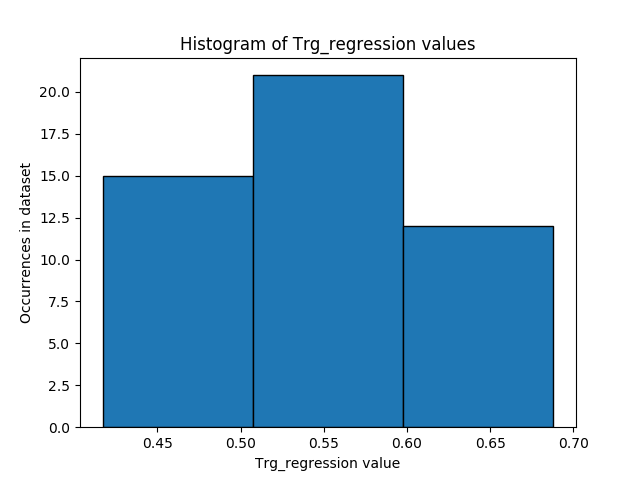

In [11]:
mastml._initialize_mastml_session()
mastml._initialize_html()
mastml._set_favorites_dict()
mastml.mastmlwrapper, mastml.configdict, errors_present = mastml._generate_mastml_wrapper()
mastml.data_setup = mastml.mastmlwrapper._process_config_keyword(keyword='Data Setup')
mastml._perform_general_setup()
data_name_list = list()
for key in mastml.configdict['Data Setup'].keys():
    if key not in data_name_list:
        data_name_list.append(key)
mastml.data_dict, y_feature = mastml._create_data_dict()
(mastml.model_list, mastml.model_vals) = mastml._gather_models(y_feature=y_feature)
test_list = mastml._string_or_list_input_to_list(mastml.models_and_tests_setup['test_cases'])

test_params = mastml.configdict["Test Parameters"][test_list[0]]
training_dataset_name_list = mastml._string_or_list_input_to_list(test_params['training_dataset'])
training_dataset_list = list()
for dname in training_dataset_name_list:
    training_dataset_list.append(mastml.data_dict[dname])
test_params['training_dataset'] = training_dataset_list

testing_dataset_name_list = mastml._string_or_list_input_to_list(test_params['testing_dataset'])
testing_dataset_list = list()
for dname in testing_dataset_name_list:
    testing_dataset_list.append(mastml.data_dict[dname])
test_params['testing_dataset'] = testing_dataset_list

target_feature = mastml.data_dict['Initial'].target_feature
test_folder = "CV_test"
test_save_path = os.path.join(mastml.save_path, test_folder)
mastml.test_save_paths.append(test_save_path)
if not os.path.isdir(test_save_path):
    os.mkdir(test_save_path)

test_type = test_list[0]
test_module = importlib.import_module('%s' % (test_type))
test_class_def = getattr(test_module, test_type)
test_class = test_class_def(model=mastml.model_list[0],save_path=test_save_path,**test_params)

### 3) Now we want to execute the test that has been setup in the previous cell. For now we won't change anything and will simply execute the test as setup in the input configuration file.
    - You should see two output plots. The first is a plot of the "best" and "worst" cross validation test. The second is an average of all the cross validation tests done.

<IPython.core.display.Javascript object>


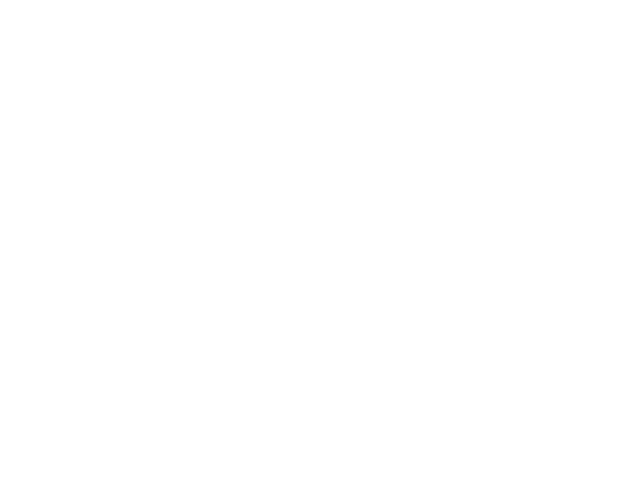

<IPython.core.display.Javascript object>


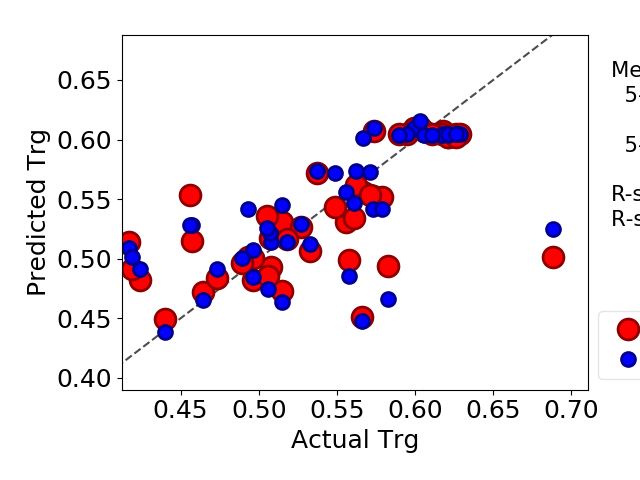

<IPython.core.display.Javascript object>


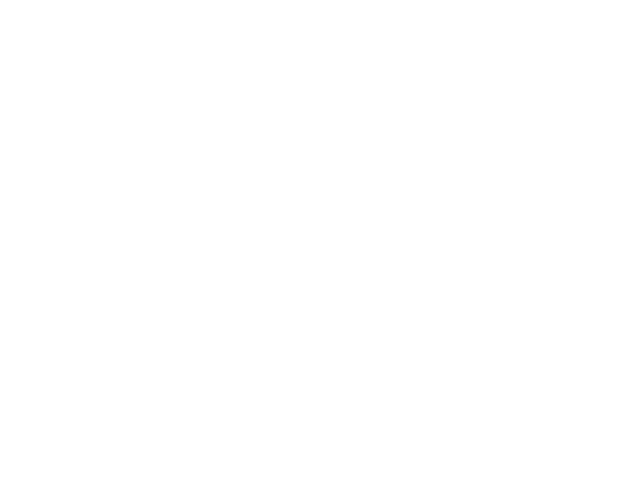

<IPython.core.display.Javascript object>


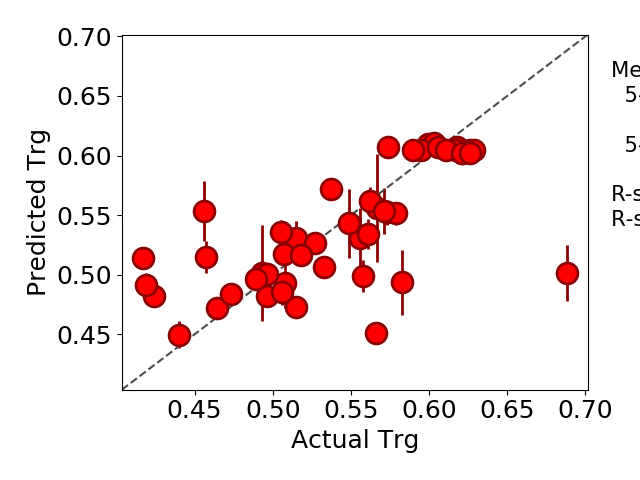

In [12]:
test_class.run()
# mastml.mastmlwrapper.get_machinelearning_test(test_type=test_list[0],
#                                             model=mastml.model_list[0], save_path=test_save_path, **test_params)

### 4) With the results from the previous test lets see what we can learn about the dataset and model. First we can look at a few overall statistics from the cross validation test.
    - The average RMSE and R2 score give us a quantitative comparison for performance across models and settings.

In [15]:
print("AVG RMSE: ", test_class.statistics['avg_fold_avg_rmses'])
print("R2 :", test_class.statistics['r2_score'])

0.0427663542685
0.527256054137


### 5) With these values as a benchmark lets experiment a bit and see what effects these values. Run the two cell below and compare what happens when we run the exact same test again. Try this a few times and to see what kind of variability is occuring.

<IPython.core.display.Javascript object>


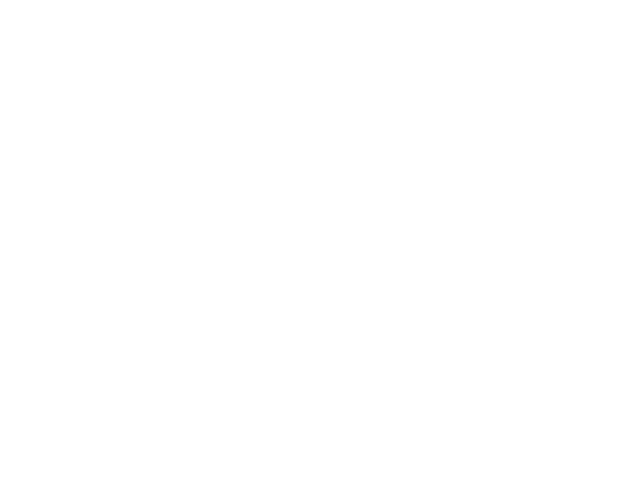

<IPython.core.display.Javascript object>


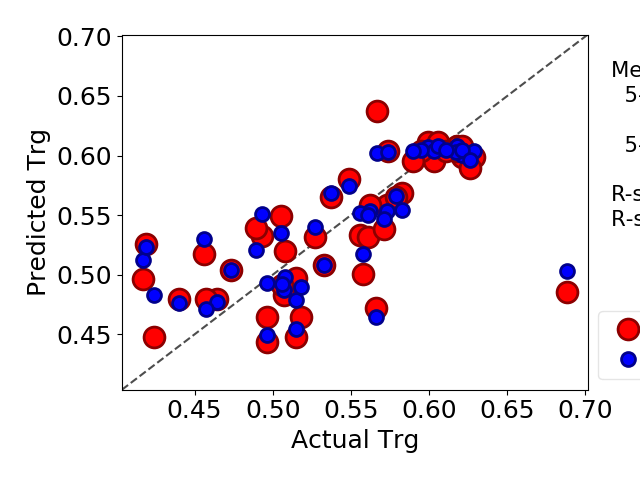

<IPython.core.display.Javascript object>


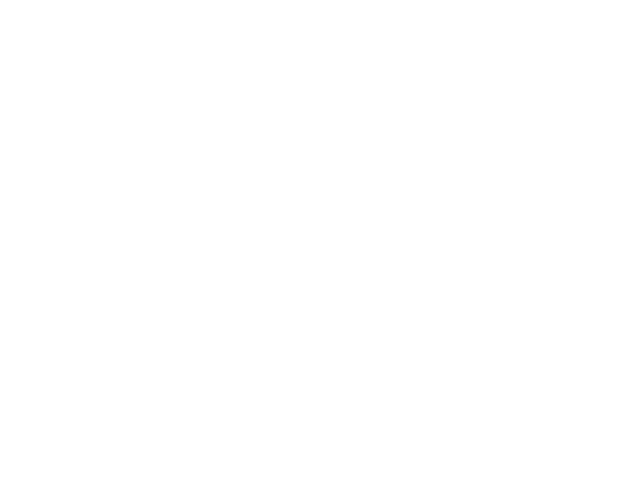

<IPython.core.display.Javascript object>


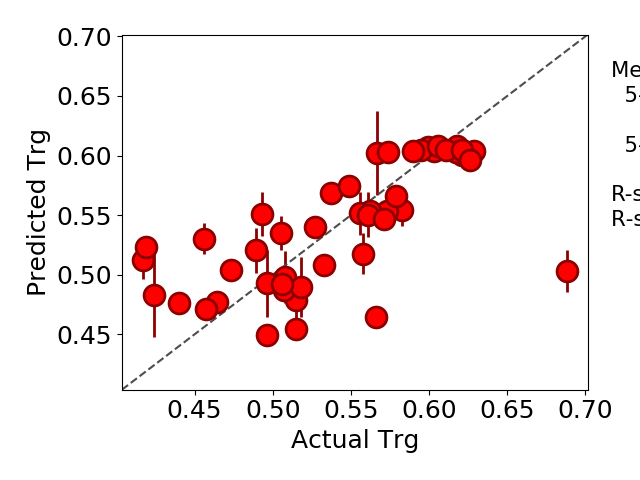

In [18]:
test_class.run()

In [19]:
print(test_class.statistics['avg_fold_avg_rmses'])
print(test_class.statistics['r2_score'])

0.0449835042869
0.484791689987


    - It is clear that there are inconsistencies in the results, and the fact that there are differences makes sense when we remember that during cross validation testing random groups are made before each cross validation step. If the groups are significantly different we might expect the results to differ as well.
    - Let's see if we can find a way to make the results of this test more consistant. We'll start by looking at the settings used in the test.

In [23]:
print("number of CV tests: ", test_class.num_cvtests)
print("number of folds", test_class.num_folds)

number of CV tests:  2
number of folds 5


### 6) We see that with the current settings we're only performing 2 cross validation tests. That means the data is only being split up 2 different ways. Lets see what happens when we increase this value (I recommend setting values up to 200 or so)

In [5]:
## change the "num_cvtests" number to see how the results are affected
test_params["num_cvtests"]=25
## 
test_class = test_class_def(model=mastml.model_list[0],save_path=test_save_path,**test_params)
test_class.run()

print("AVG RMSE: ", test_class.statistics['avg_fold_avg_rmses'])
print("R2 :", test_class.statistics['r2_score'])

NameError: name 'test_params' is not defined

### 7) Compare these new results with those found previously and consider the following
    How are they similar? 
    How are they different?
    Did increasing the number of CV tests reduce variability in results?
    What values of num_cvtests do you think are sufficient to properly estimate the model performance?

### 8) Lets repeat 6) and 7) above for another parameter that we can change about the CV tests. In this case we want to modify the number of "folds" used in the cross validation testing. To put it simply the number of folds tells the codes how many random groups to split the data into for each cross validation test. For example with 10 data points and num_folds=5 the data will be split into 5 random groups of 2. Each group of 2 is then used as the validation data for the other 8 datapoints. (If this is confusing I encourage you to watch the following short youtube video which should hopefully explain better (https://www.youtube.com/watch?v=TIgfjmp-4BA).

<IPython.core.display.Javascript object>


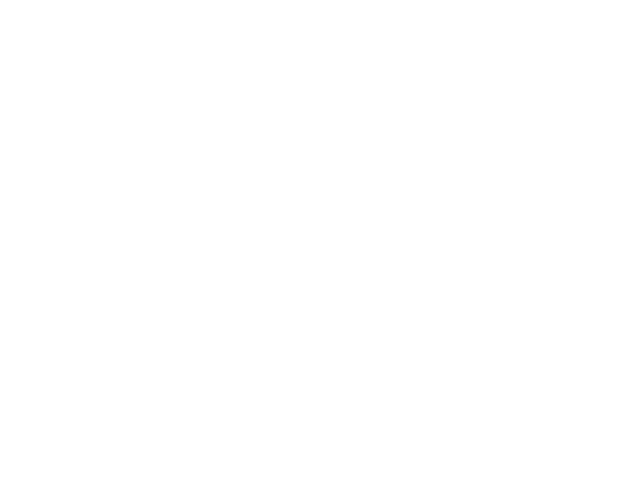

<IPython.core.display.Javascript object>


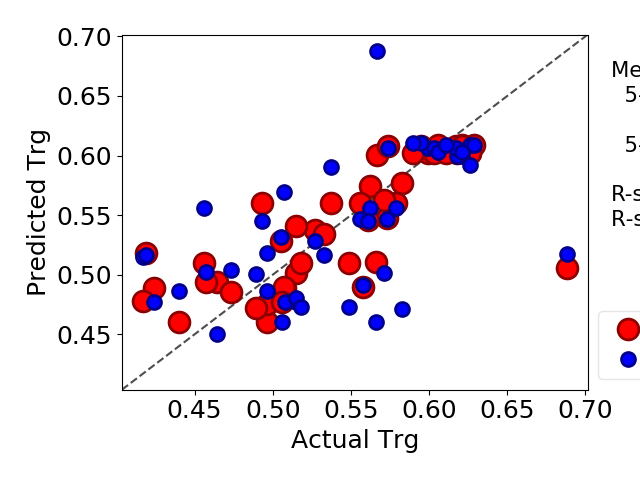

<IPython.core.display.Javascript object>


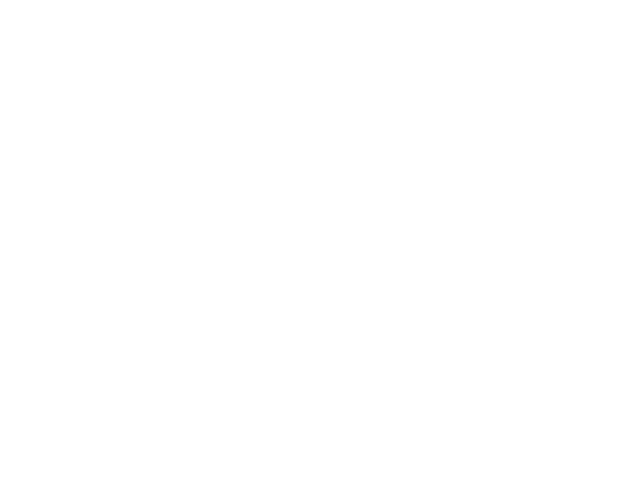

<IPython.core.display.Javascript object>


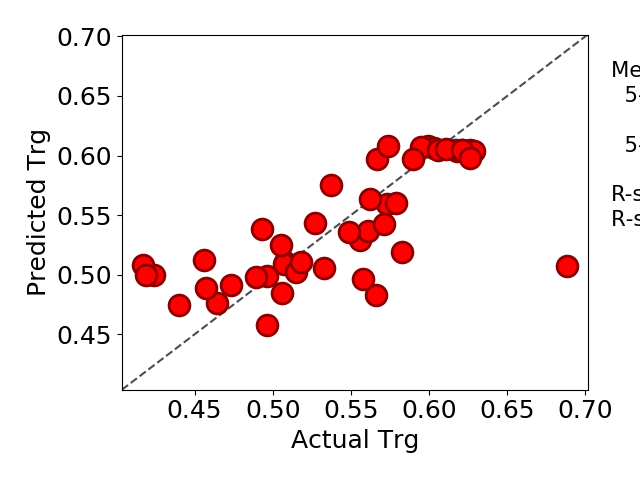

0.0445831254378
0.539927340071


In [41]:
## change the "num_folds" number to see how results are affected
test_params["num_folds"]=5
##
test_class = test_class_def(model=mastml.model_list[0],save_path=test_save_path,**test_params)
test_class.run()

print("AVG RMSE: ", test_class.statistics['avg_fold_avg_rmses'])
print("R2 :", test_class.statistics['r2_score'])

### 9) Now that we've seen how the parameters used in cross validation can affect results, lets look a bit at the actual results that we are seeing. The questions we want to answer are:
    What information is being shown?
    What is it trying to estimate?
    What does it tell us about the model?
    How can we use the results to improve the model?
    
Try to come up with your own answers to these, and then confer with the thoughts two cells down.

<IPython.core.display.Javascript object>


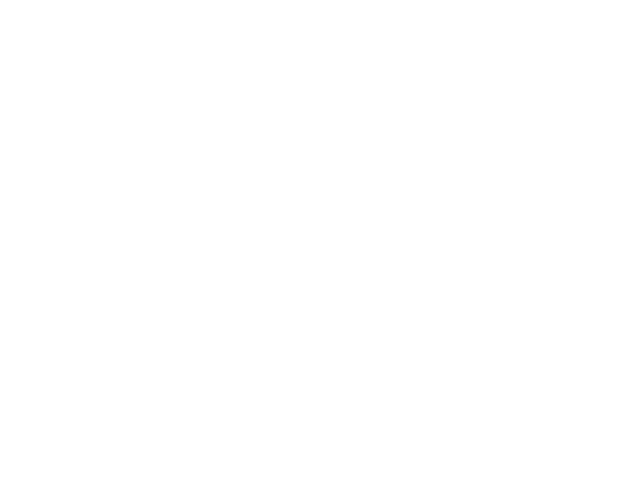

<IPython.core.display.Javascript object>


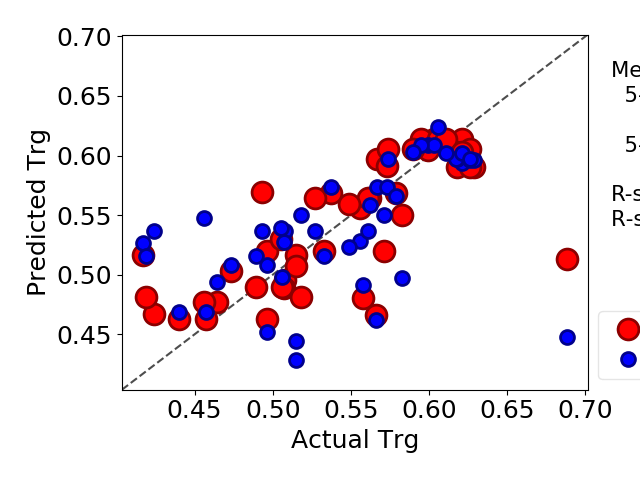

<IPython.core.display.Javascript object>


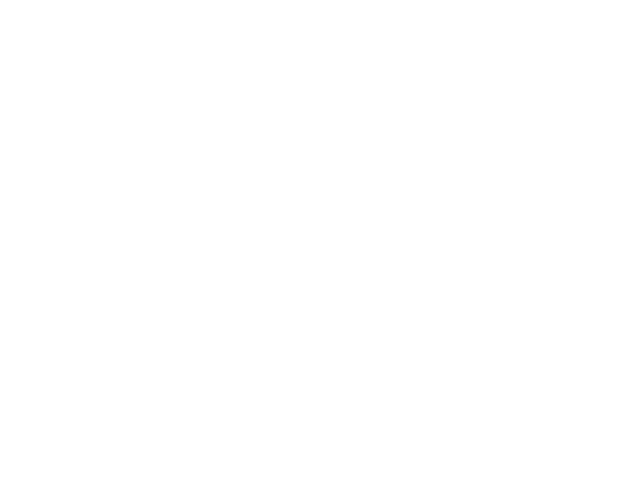

<IPython.core.display.Javascript object>


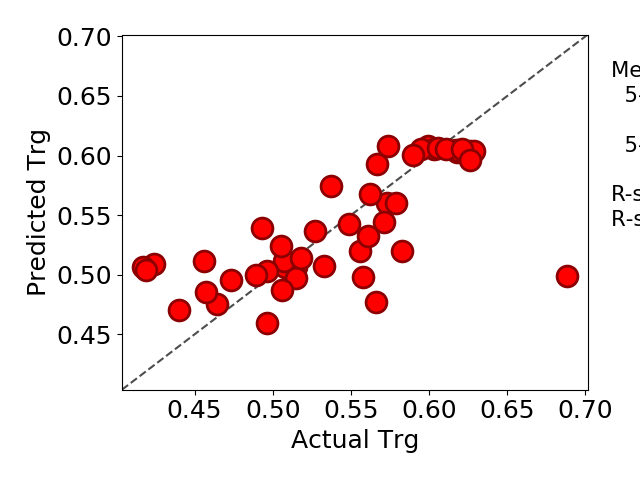

AVG RMSE:  0.0453832212774
R2 : 0.515044289293


In [43]:
test_params["num_cvtests"]=50
test_params["num_folds"]=5
test_class = test_class_def(model=mastml.model_list[0],save_path=test_save_path,**test_params)
test_class.run()

print("AVG RMSE: ", test_class.statistics['avg_fold_avg_rmses'])
print("R2 :", test_class.statistics['r2_score'])


    What information is being shown?

The average prediction (or best and worst) across many different models, all of which are using randomly generated subsets of our overall dataset.

    What does this try to estimate?

cross validation tests try to estimate model performance when predicting new datapoints that haven't been introduced to the model previously. 

    What does it tell us about the model?
    
There a many things we might notice about the model. Included are:
-Model performance might vary across the data range performing better in some areas than others.
-Certain groups (material compositions for example) may perform better or worse
-Overall model accuracy (through RMSE type statistics)
    
    How can we use the results to improve the model?
    
Depending on the results we may decide to include new features, more data if available, different types of data, or different optimization techniques

# Conclusions

Cross Validation tests are a powerful tool for understanding real world model performance. Hopefully running through the brief walkthrough on MASTML's cross validation tests will help to know how to set them up correctly, and how to understand the results that are given. 

# Appendix

In [9]:
test_class.statistics

{'average_prediction': array([ 0.52060436,  0.50419356,  0.53646345,  0.48338769,  0.62325444,
         0.49662818,  0.4922838 ,  0.6042197 ,  0.60628446,  0.60877671,
         0.61084146,  0.59943459,  0.59438233,  0.60526004,  0.60910598,
         0.52554968,  0.60519389,  0.60480567,  0.60519389,  0.59943459,
         0.56403361,  0.56938808,  0.55706655,  0.56977607,  0.5421682 ,
         0.51587472,  0.5541569 ,  0.53226939,  0.51286065,  0.49924516,
         0.53054496,  0.4851274 ,  0.4742774 ,  0.4900111 ,  0.48868988,
         0.5053396 ,  0.50079777,  0.496196  ,  0.49938984,  0.51431085,
         0.55471701,  0.54265266,  0.57166098,  0.57166098,  0.52831298,
         0.52944009,  0.53727727,  0.50563262]),
 'avg_fold_avg_mean_errors': 0.00067992083517519775,
 'avg_fold_avg_rmses': 0.042766354268497411,
 'fold_avg_rmse_best': 0.041288003068611398,
 'fold_avg_rmse_worst': 0.044244705468383418,
 'r2_score': 0.52725605413736021,
 'r2_score_noint': 0.029111370748733489,
 'std_er

In [10]:
dir(test_class)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'analysis_name',
 'best_test_index',
 'cv_fit_and_predict',
 'cvmodel',
 'cvtest_dict',
 'fit',
 'get_mean_absolute_error',
 'get_mean_error',
 'get_plot_filter',
 'get_prediction',
 'get_rmse',
 'get_rsquared',
 'get_rsquared_noint',
 'get_statistics',
 'get_trained_model',
 'mark_outlying_points',
 'model',
 'num_cvtests',
 'num_folds',
 'percent_leave_out',
 'plot',
 'plot_best_worst_overlay',
 'plot_filter_out',
 'plot_filter_update_statistics',
 'plot_meancv_overlay',
 'plot_results',
 'predict',
 'print_best_worst_output_csv',
 'print_model',
 'print_output_csv',
 'print_readme',
 'print_s

In [30]:
test_params

{'training_dataset': [<DataHandler.DataHandler object at 0x000000000C8DF780>], 'testing_dataset': [<DataHandler.DataHandler object at 0x000000000C8DF780>], 'xlabel': 'Actual Trg', 'ylabel': 'Predicted Trg', 'num_folds': '5', 'num_cvtests': '2'}

In [ ]:
update conf file

test.tofile()